# neptune setup
* export NEPTUNE_API_TOKEN="..."

In [1]:
import neptune.new as neptune

# 새로 실험 아이디 얻고 싶을때
#run = neptune.init(project='hakmink/pycaret', tags=['regression','interpretml'], api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJjMjRiNGE3MS0wYmFlLTQyMjktODhkNy0wZTNmNmM4NmE0ZWUifQ==')
#run = neptune.init(project='hakmink/pycaret', tags=['regression','interpretml'])

# rerun
run = neptune.init(project='hakmink/pycaret', run='PYCAR-12', tags=['regression','interpretml'])

Info (NVML): NVML Shared Library Not Found. GPU usage metrics may not be reported. For more information, see https://docs-legacy.neptune.ai/logging-and-managing-experiment-results/logging-experiment-data.html#hardware-consumption 


https://app.neptune.ai/hakmink/pycaret/e/PYCAR-12


## default fields setup
* inspired by pycaret mlflow ui

In [2]:
run['run name'] = 'base model' # your exp name
run['source'] = 'jupyter'
run['version'] = ''


run['mae'] = 0.0
run['mse'] = 0.0
run['rmse'] = 0.0
run['r2'] = 0.0
run['rmsle'] = 0.0
run['mape'] = 0.0
run['algorithm'] = ''

# library & data load

In [8]:
from os import path
import pandas as pd
import numpy as np
import reducing
import pickle


np.random.seed(0)
df_pickle = '../data/wine_data/original_df.pickle'
wine_file = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'
if path.exists(df_pickle):
    with open(df_pickle, 'rb') as handle:
        df = pickle.load(handle)
else:
    df = reducing.import_data(wine_file, delimiter=';')
    #for later use, save df as pickle
    with open(df_pickle, 'wb') as handle:
        pickle.dump(df, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [9]:
df.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0       7.398438          0.700195     0.000000        1.900391   0.075989   
1       7.800781          0.879883     0.000000        2.599609   0.098022   
2       7.800781          0.759766     0.040009        2.300781   0.091980   
3      11.203125          0.280029     0.560059        1.900391   0.075012   
4       7.398438          0.700195     0.000000        1.900391   0.075989   

   free sulfur dioxide  total sulfur dioxide   density        pH  sulphates  \
0                 11.0                  34.0  0.997559  3.509766   0.560059   
1                 25.0                  67.0  0.996582  3.199219   0.680176   
2                 15.0                  54.0  0.997070  3.259766   0.649902   
3                 17.0                  60.0  0.998047  3.160156   0.580078   
4                 11.0                  34.0  0.997559  3.509766   0.560059   

    alcohol  quality  
0  9.398438        5  
1  9.796875        5  
2  9.796875        5  
3  9.796875        6  
4  9.398438        5

In [10]:
df.dtypes

fixed acidity           float16
volatile acidity        float16
citric acid             float16
residual sugar          float16
chlorides               float16
free sulfur dioxide     float16
total sulfur dioxide    float16
density                 float16
pH                      float16
sulphates               float16
alcohol                 float16
quality                    int8
dtype: object

## Sample data - neptune upload

In [11]:
from util import write_to_html_file
from neptune.new.types import File


write_to_html_file(df.head(), title='Sample - Wine Data', filename='sample_data.html')

run['data/sample'].upload('sample_data.html')

In [12]:
isna_info = df.isna().describe()

write_to_html_file(isna_info, title='Describe Data - isna', filename='isna.html')

run['data/isna'].upload('isna.html')

## Profiling report - neptune upload
* https://pandas-profiling.github.io/pandas-profiling/docs/master/rtd/pages/advanced_usage.html

In [14]:
from pandas_profiling import ProfileReport
profile = ProfileReport(df.sample(frac=0.1), 
                        explorative=True,
                        correlations={
                            "pearson": {"calculate": False},
                            "spearman": {"calculate": False},
                            "kendall": {"calculate": False},
                            "phi_k": {"calculate": False},
                            "cramers": {"calculate": False},
                        },
)


#Saving results to a HTML file
profile.to_file("profile_data.html")

run['data/profile'].upload('profile_data.html')

Summarize dataset:   0%|          | 0/21 [00:00<?, ?it/s]

/Users/a405305/opt/anaconda3/envs/pycaret/lib/python3.8/site-packages/numpy/core/_methods.py:216: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)
/Users/a405305/opt/anaconda3/envs/pycaret/lib/python3.8/site-packages/numpy/core/_methods.py:216: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

# Machine Learning Setup

## pycaret 2.2 what is new
* https://towardsdatascience.com/pycaret-2-2-is-here-whats-new-ad7612ca63b
* gpu enabled
* refactored to improve memory footprint and optimize performance
> 5M sampled rows from the famous New York Taxi Dataset (AMD64 machine with 8 CPU cores)
-> 9min 23s (v2.1) VS 39.9s (v2.2) 
* add_metric
```
# add Log Loss metric in pycaret
from sklearn.metrics import log_loss
add_metric(id='logloss', 
           name='LogLoss', 
           score_func=log_loss, 
           target='pred_proba',
           greater_is_better=False)
```
* skip preprocessing
```
# initializing setup
from pycaret.classification import *
clf = setup(data = train_data, preprocess = False) 
```
* separate train and test set
```
# loading dataset
import pandas as pd
train_data = pd.read_csv('/path/train.csv')
test_data = pd.read_csv('/path/test.csv')
# initializing setup
from pycaret.classification import *
clf = setup(data = train_data, test_data = test_data)
```

In [9]:
from pycaret.regression import *
reg1 = setup(df, target = 'quality', 
             session_id=123, 
             train_size=0.8,
             fold=2,
             log_experiment=True, 
             combine_rare_levels=True,
             experiment_name='wine3')

## get config

In [10]:
get_config('X').head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0       7.398438          0.700195     0.000000        1.900391   0.075989   
1       7.800781          0.879883     0.000000        2.599609   0.098022   
2       7.800781          0.759766     0.040009        2.300781   0.091980   
3      11.203125          0.280029     0.560059        1.900391   0.075012   
4       7.398438          0.700195     0.000000        1.900391   0.075989   

   free sulfur dioxide  total sulfur dioxide   density        pH  sulphates  \
0                 11.0                  34.0  0.997559  3.509766   0.560059   
1                 25.0                  67.0  0.996582  3.199219   0.680176   
2                 15.0                  54.0  0.997070  3.259766   0.649902   
3                 17.0                  60.0  0.998047  3.160156   0.580078   
4                 11.0                  34.0  0.997559  3.509766   0.560059   

    alcohol  
0  9.398438  
1  9.796875  
2  9.796875  
3  9.796875  
4  9.398438

In [11]:
get_config('y').head()

0    5
1    5
2    5
3    6
4    5
Name: quality, dtype: int8

## Setup reporting

In [12]:
setup_info = get_config('display_container')[-1].render()
with open('setup_info.html', 'w') as f:
    f.write(setup_info)
run['model/setup_info'].upload('setup_info.html')

## Compare Models

In [14]:
best_model = compare_models(include = ['rf','lightgbm','catboost','en'], sort='RMSE')
best_model

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=123, verbose=0, warm_start=False)

In [15]:
best_model_result = pull()
display(best_model_result)
# same
best_model_result = get_config('display_container')[-1]
display(best_model_result)

Model     MAE     MSE    RMSE      R2  \
rf                Random Forest Regressor  0.4466  0.3686  0.6067  0.4301   
catboost               CatBoost Regressor  0.4545  0.3783  0.6146  0.4152   
lightgbm  Light Gradient Boosting Machine  0.4655  0.3928  0.6265  0.3923   
en                            Elastic Net  0.6504  0.6330  0.7955  0.0196   

           RMSLE    MAPE  TT (Sec)  
rf        0.0940  0.0822     0.310  
catboost  0.0950  0.0832     0.775  
lightgbm  0.0966  0.0851     1.705  
en        0.1218  0.1194     0.020

Model     MAE     MSE    RMSE      R2  \
rf                Random Forest Regressor  0.4466  0.3686  0.6067  0.4301   
catboost               CatBoost Regressor  0.4545  0.3783  0.6146  0.4152   
lightgbm  Light Gradient Boosting Machine  0.4655  0.3928  0.6265  0.3923   
en                            Elastic Net  0.6504  0.6330  0.7955  0.0196   

           RMSLE    MAPE  TT (Sec)  
rf        0.0940  0.0822     0.310  
catboost  0.0950  0.0832     0.775  
lightgbm  0.0966  0.0851     1.705  
en        0.1218  0.1194     0.020

In [16]:
run["model/best_model"] = best_model

write_to_html_file(get_config('display_container')[-1], title='Best Model', filename='best_model_result.html')
run['model/best_model_comparison'].upload('best_model_result.html')

## Create Model - lightgbm

In [20]:
lightgbm = create_model('lightgbm')

In [21]:
model_name = 'lightgbm'
title = '{model_name} - before hyperparameter tuning'.format(model_name=model_name)
filename = '{model_name}_before_tuned'.format(model_name=model_name)

write_to_html_file(get_config('display_container')[-1], 
                   title=title, 
                   filename=filename+'.html')
run['model/'+filename].upload(filename+'.html')
run['model/'+model_name] = lightgbm

## Hyperparameter Tunning

In [22]:
tuned_lightgbm = tune_model(lightgbm, search_library='scikit-optimize', search_algorithm='bayesian', optimize='RMSE')

In [23]:
model_name = 'lightgbm'
title = '{model_name} - after hyperparameter tuning'.format(model_name=model_name)
filename = '{model_name}_after_tuned'.format(model_name=model_name)

write_to_html_file(get_config('display_container')[-1], 
                   title=title, 
                   filename=filename+'.html')
run['model/'+filename].upload(filename+'.html')
run['model/'+model_name] = tuned_lightgbm


In [24]:
mae = get_config('display_container')[-1]['MAE']['Mean']
mse = get_config('display_container')[-1]['MSE']['Mean']
rmse = get_config('display_container')[-1]['RMSE']['Mean']
r2 = get_config('display_container')[-1]['R2']['Mean']
rmsle = get_config('display_container')[-1]['RMSLE']['Mean']
mape = get_config('display_container')[-1]['MAPE']['Mean']

run['mae'] = mae
run['mse'] = mse
run['rmse'] = rmse
run['r2'] = r2
run['rmsle'] = rmsle
run['mape'] = mape
run['algorithm'] = 'tuned_lightgbm'

# Interpret Model

## Plot Model

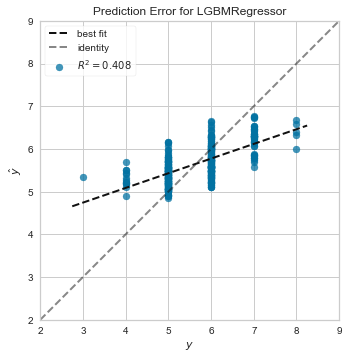

In [25]:
plot_model(tuned_lightgbm, 'error')

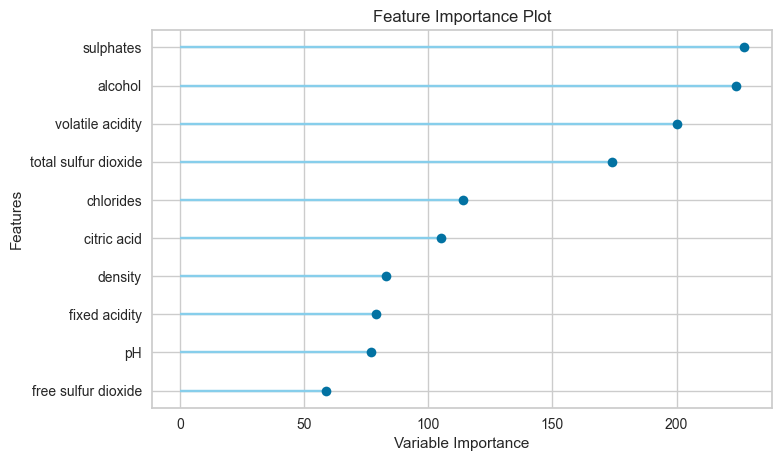

In [26]:
plot_model(tuned_lightgbm, 'feature')

In [27]:
plot_model(tuned_lightgbm, 'parameter')

Parameters
boosting_type                       gbdt
class_weight                        None
colsample_bytree                     1.0
importance_type                    split
learning_rate       0.016133245419918712
max_depth                             -1
min_child_samples                     95
min_child_weight                   0.001
min_split_gain        0.8209314243567916
n_estimators                         239
n_jobs                                -1
num_leaves                           183
objective                           None
random_state                         123
reg_alpha          8.662569304197528e-07
reg_lambda         5.001062744294253e-06
silent                              True
subsample                            1.0
subsample_for_bin                 200000
subsample_freq                         0
bagging_fraction      0.8608120752388259
bagging_freq                           1
feature_fraction      0.4284489606984907

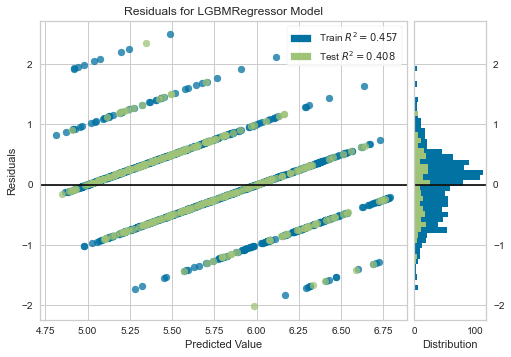

In [28]:
plot_model(tuned_lightgbm, 'residuals')

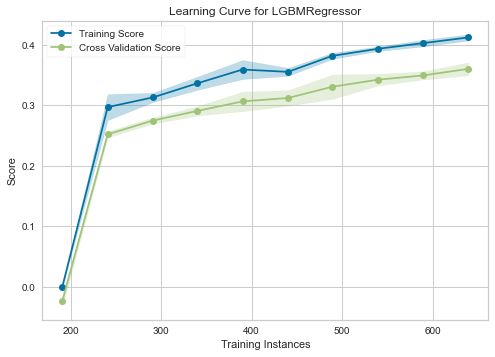

In [30]:
plot_model(tuned_lightgbm, 'learning')

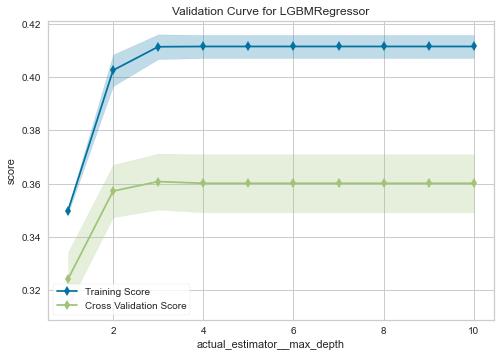

In [31]:
plot_model(tuned_lightgbm, 'vc')

## Summary

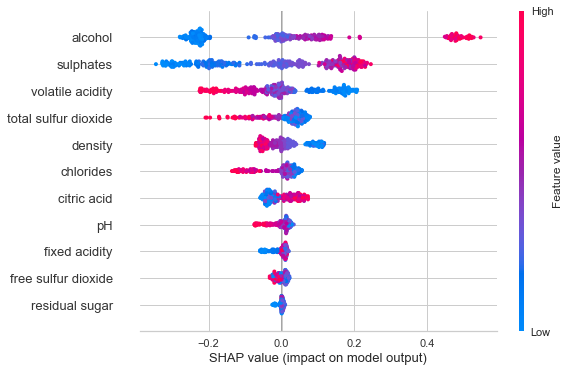

In [32]:
interpret_model(tuned_lightgbm)

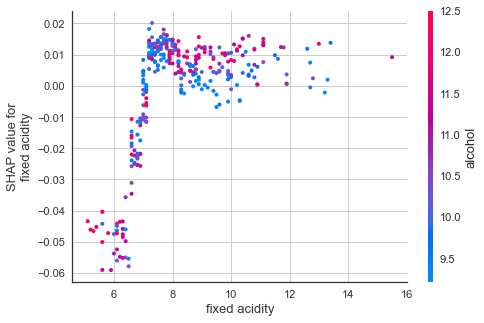

In [33]:
interpret_model(tuned_lightgbm, plot = 'correlation')

In [34]:
interpret_model(tuned_lightgbm, plot = 'reason', observation = 10)

In [ ]:
!mlflow ui